## Plummer sphere
The Plummer sphere density profile is

$$
\rho \left( R \right) = \frac{3 M_{tot}}{4\pi b^3}\  \left(1 + \dfrac{r^2}{b^2}\right)^{-5/2}
$$

$\newline$

To initialize the Plummer sphere we need to set the correct distributions for our particles cartesian coordinates. To do so we first need to find the spherical coordinates and then project them onto the cartesian plane. 

The mass can be found by simple integration over the volume, which yields

$$
    M(r) = M_\text{tot}\ \dfrac{r^3}{b^3}\ \left(1 + \dfrac{r^2}{b^2}\right)^{-3/2}
$$
$\newline$

Inverting the relation for $\xi = M(r)/M_{tot}$ we obtain that 

$$
\begin{cases}
    \ R\ =\ b\ \sqrt{\left( \dfrac{ \xi^{2/3}}{1-\xi^{2/3}}\right)} && 0 \le \xi \le 1 \\ \\
    \ \varphi = \tilde{\varphi} && 0 \le \tilde{\varphi} \le 2 \pi \\ \\
    \ \theta = \arccos(1-2 \omega) &&  0 \le \omega \le 1 
\end{cases}
$$

$\newline$

Now that we have the spherical coordinates we need to initialize their distribution, in this case a direct montecarlo takes care of it. We just initialize the cumulative and calculate the radii

## Initial positions

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm.notebook import tqdm
from IPython.display import HTML

plt.style.use('../../sim.mplstyle')
%config InlineBackend.figure_format = 'retina'

In [2]:
import sys
sys.path.insert(1, '../')
from gdsam import initial_data

We can show a contour plot of the density profile

In [3]:
def density(r):
    return 3*M/(4*np.pi*b**3)*(1+r**2/b**2)**(-5/2)

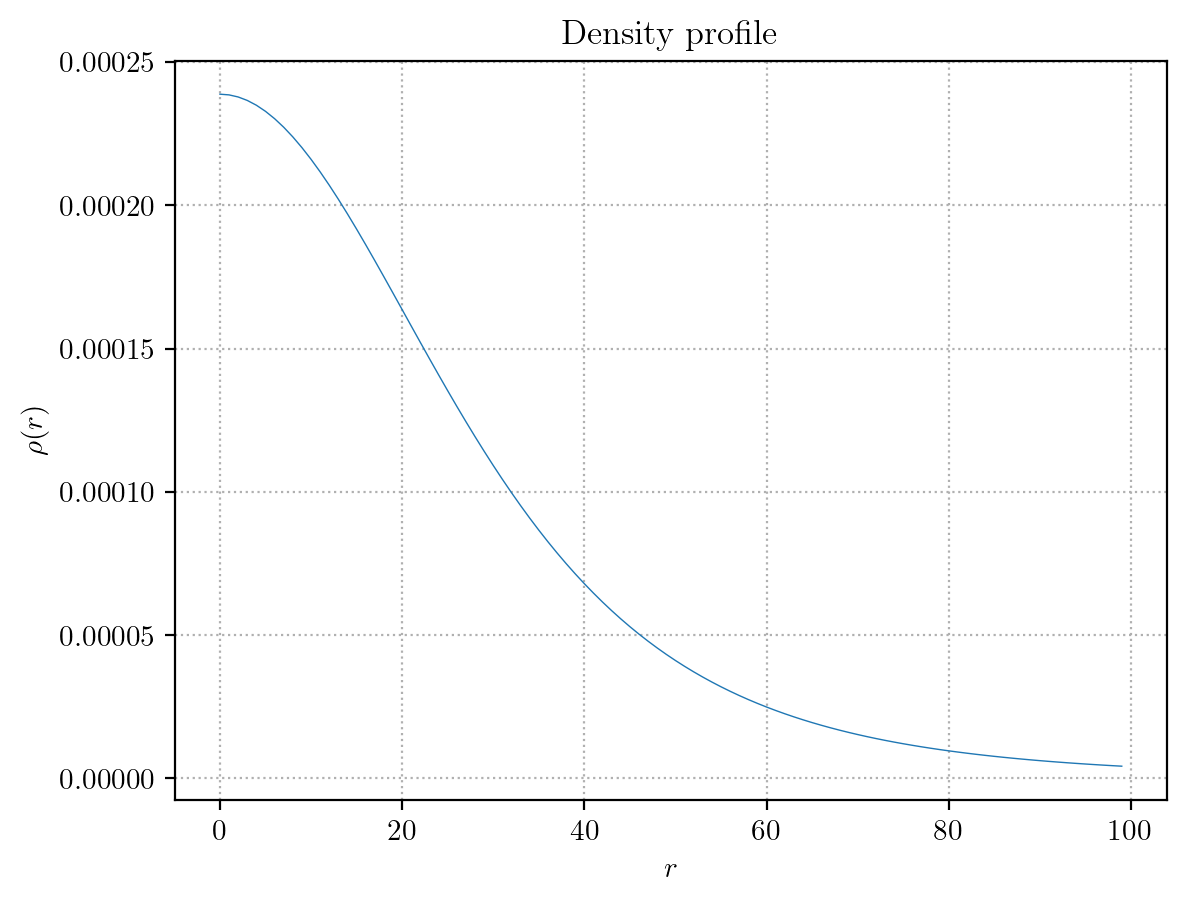

In [7]:
r = np.linspace(0, 20, 100)
M = 1
b = 10

plt.plot(density(r))
plt.xlabel(r'$r$')
plt.ylabel(r'$\rho(r)$')
plt.title(r'Density profile')
plt.grid()
plt.show();

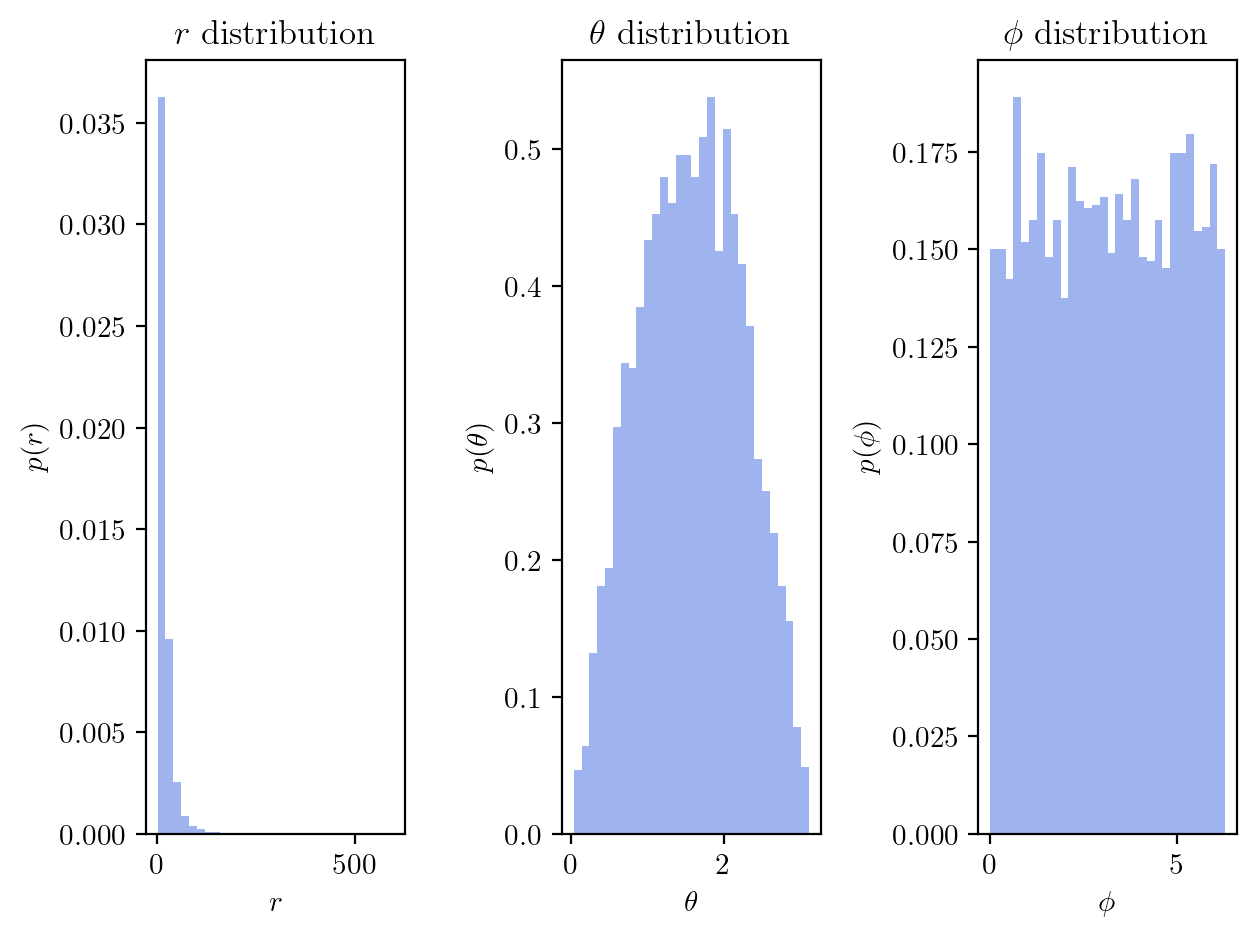

In [8]:
sphere = initial_data()
N = '5e3'
sphere.plummer_model(int(float(N)), M, b)
sphere.show_dist_sph()

plt.show()

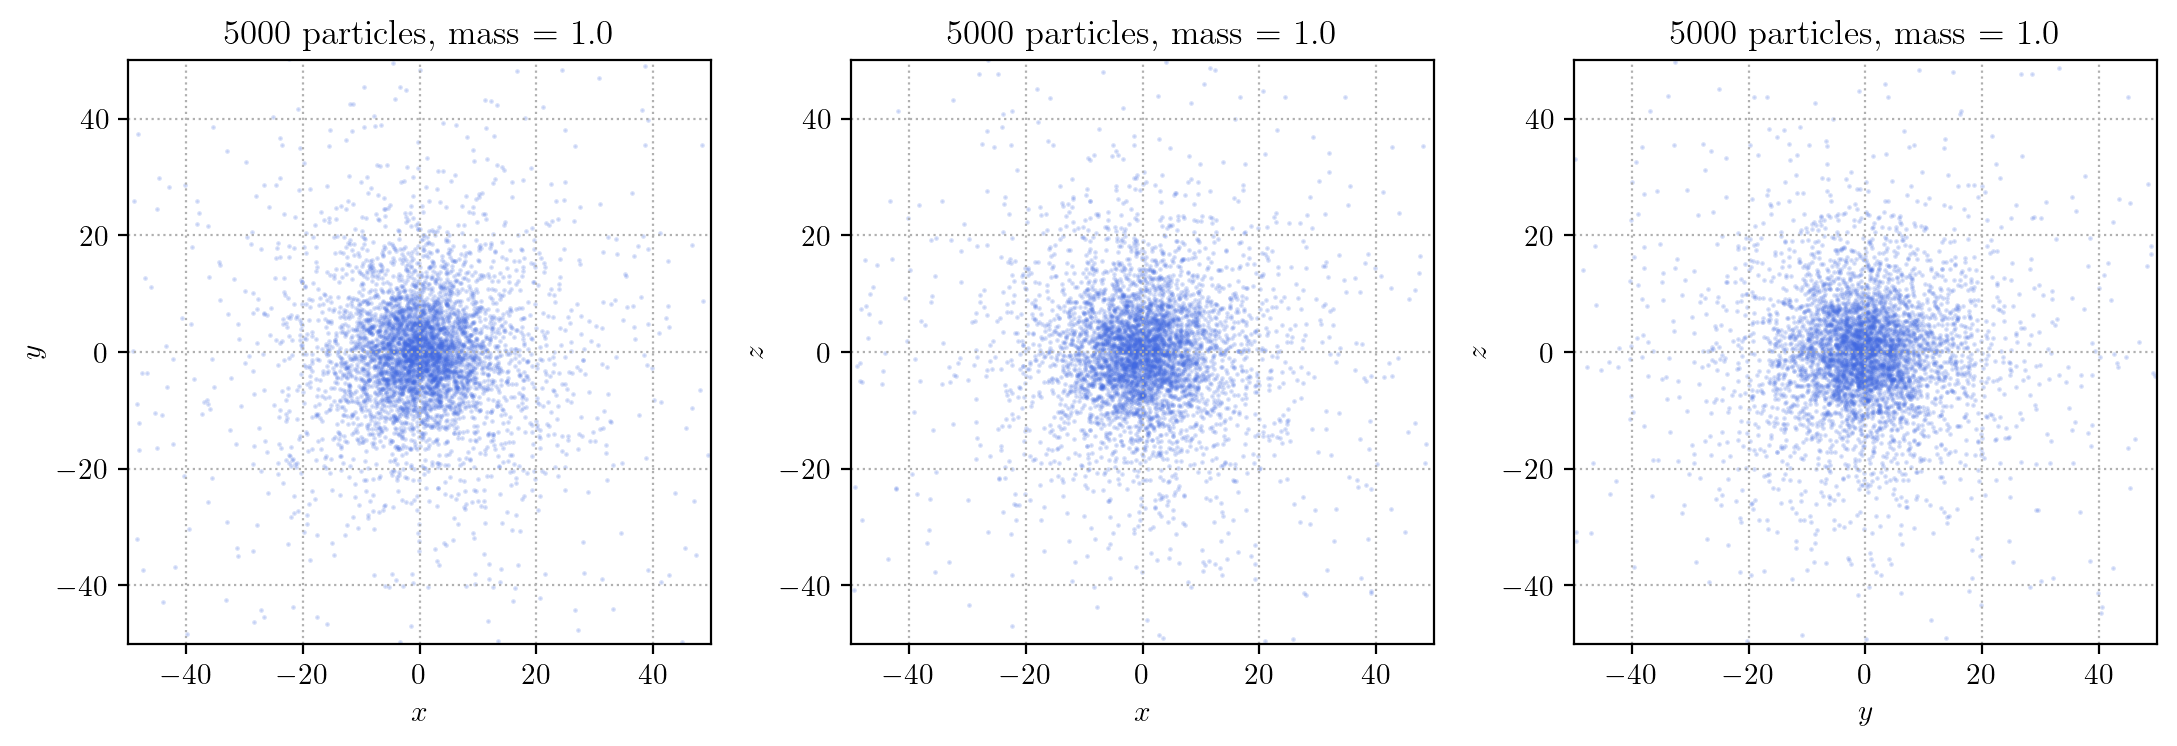

In [59]:
sphere.projections(s=.5,a=.2, l=50);

Finally we calculate the potential, which is simply 

$$
    \phi = - \dfrac{GM_\text{tot}}{\sqrt{r^2 + b^2}}
$$

But in the new formalism we will use the following quantity 

$$
    \psi = - \phi + \phi_0 = \dfrac{GM_\text{tot}}{\sqrt{r^2 + b^2}}
$$

In [36]:
# we are still in internal units
G = 1
M = np.sum(sphere.m)
R = sphere.r

Psi = G * M /(R**2 + b**2)**(1/2)

## Initial velocities

The velocity distribution is isotropic. 

For bound orbits, the new formalism introduces an adimensional parameter $q$ which is simply the velocity of particles normalized to their escape velocity. If we want to calculate the velocity we need to flip this relation

$$
\vert \vec{v} \vert = q \sqrt{\psi}
$$
 
Now the $q$ distribution can be found by using the inverse of the cumulative. First let's caclulate the cdf, recalling that $\varepsilon = - E + \phi_0 = \psi - \frac{1}{2} v^2 $

$$
    F(\varepsilon) = \int_0^\varepsilon f(\varepsilon) \ d^3v = \int_0^\varepsilon dv\ 4\pi v^2 \ f(\varepsilon)
$$

And now one can extract the velocity from the definition of $\varepsilon$ simply by expressing the potential $\psi$ in terms of the velocity. After a few algebraic steps you find

$$
 F(q) = A \int_0^q q^2 \left(1-q^2\right)^{7/2}\ dq
$$

With $A$ normalization constant. Now that we have our cumulative our job would be to invert this relation analytically and then sample using inverse montecarlo, but this is really hard with this function. Plus we don't know the magnitude of the normalization constant. So we will use rejection method instead of inversion.

- Compute the normalization constant
- sample q with the Montecarlo rejection method
- Compute the magnitude of the velocities.  $\vert \vec{v} \vert = q \sqrt{\Psi}$
Since the distribution is isotropic, it should form a sphere in velocity space.

$\newline$

$$
\begin{cases}
   \vert \vec{v} \vert = q \sqrt{\Psi} &&  0 \le q \le 1  && \text{with rejection on $F(q)$} \\ \\
    v_{\varphi} = \tilde{\varphi} && 0 \le \tilde{\varphi} \le 2 \pi \\ \\
    v_{\theta} = \arccos(1-2 \omega) &&  0 \le \omega \le 1 
\end{cases}
$$

$\newline$

And we simply project onto the cartresian plane.

$$
\begin{cases}
   v_{x} = \vert \vec{v} \vert \cos(v_{\varphi}) \sin(v_{\theta}) \\
   v_{y} = \vert \vec{v} \vert \sin(v_{\varphi}) \sin(v_{\theta}) \\
   v_{z} = \vert \vec{v} \vert  \cos(v_{\theta})
\end{cases}
$$

### Rejection method 101
We need to find a function $g(x)$ such that is larger than the pdf $f(x)$ for each $x$, this means we need to differentiate our $F(x)$ but this is very easy since we can just use the fundamental theorem of calculus and find

$$
    f(x) = A q^2 \ \left( 1 - q^2 \right)^{7/2}
$$

After we find a good choice for $g(x)$ we will compute the cumulative and the inverse of the cumulative to obtain some samples $y$ with inverse montecarlo method.
Then we accept only those $y$ such that $y < f(x)$.

We start by estimating the normalization constant for the pdf on $q$, to do so we use the distribution of the radial velocities and integrate it from 0 to 1

In [37]:
import scipy.integrate as integrate

pdf_test = lambda x: (x**2*(1-x**2)**(3.5)) #our f(x)
A = integrate.quad(pdf_test,0,1)  #simple way to compute the normalization constant

Now we sample our $q$ using as pdf the normalized pdf (divided by $A$). We start with more $q$ samples than we actually need because rejection is going to eliminate part of them.

In [38]:
q = np.linspace(0,1, int(1e6))
pdf_func = lambda x: 1/A[0]*(x**2*(1-x**2)**(3.5))
#the pdf obtained

g = np.full(int(1e6), np.max(pdf_func(q))) + 1 #the bigger function, just a constant line at the maximum of f(x) + 1

In [39]:
#rejection method for q, because it's hard to compute the inverse
q_sample = []

for i in range(int(float(N))):
    y_rand = np.max(g) # i start with a value of y
    rand = np.random.uniform(0,1) #i extract a new sample
    while y_rand > pdf_func(rand): #if the function calculated at the sample is less than y
        rand = np.random.uniform(0,1) #i reject the old sample
        y_rand = np.random.uniform(0,np.max(g)) #i extract a new y until it exits the loop

    q_sample.append(rand) #i collect the samples below the upper function

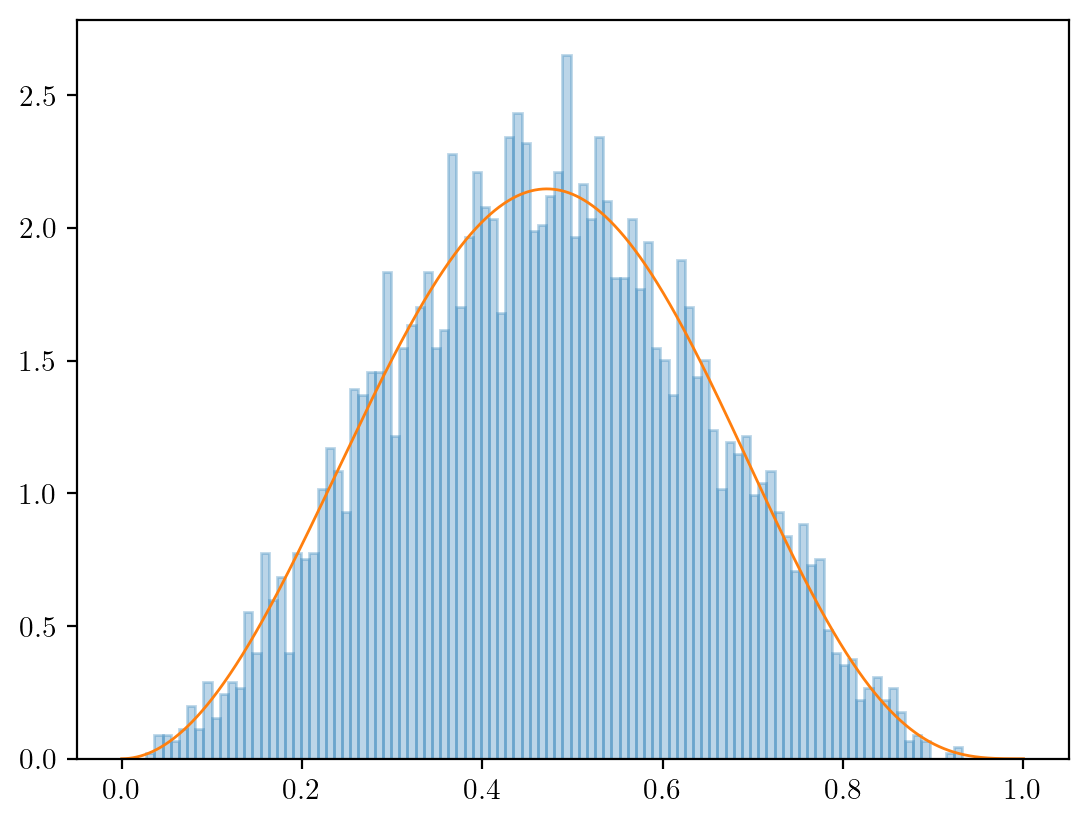

In [41]:
q_sample = np.array(q_sample)
plt.hist(q_sample,100, density=True, edgecolor='tab:blue', alpha = .3)
plt.plot(q,pdf_func(q), lw=1);

In [42]:
N_ = int(float(N))

v = q_sample * np.sqrt(2 * Psi)
v_theta_cdf = np.random.uniform(0,1,N_)
v_theta = np.arccos(1 - 2 * v_theta_cdf)
v_phi = np.random.uniform(0, 2 * np.pi, size=N_)

vx = v * np.cos(v_phi) * np.sin(v_theta)
vy = v * np.sin(v_phi) * np.sin(v_theta)
vz = v * np.cos(v_theta)

In [52]:
sphere.set_velocities(vx, vy, vz)

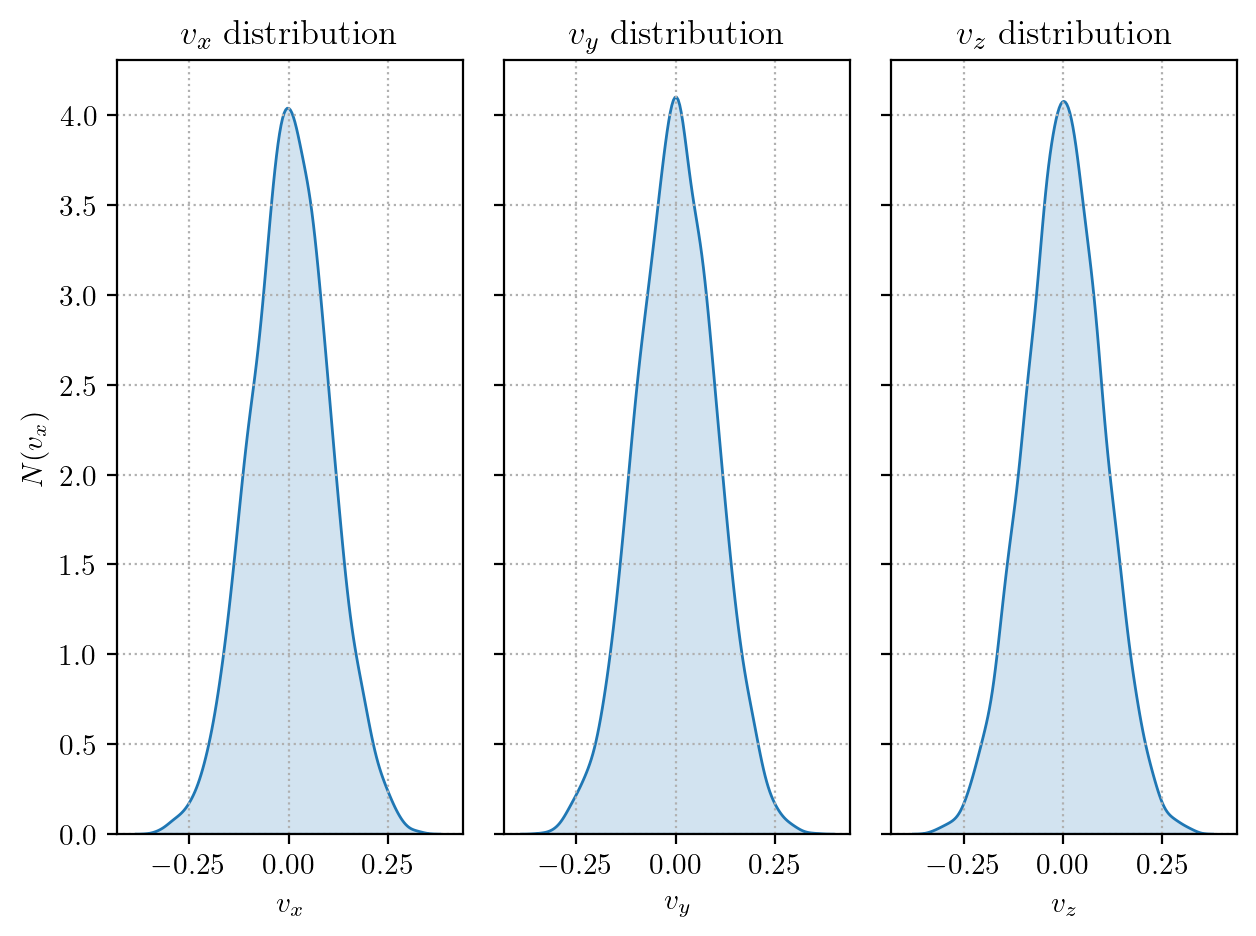

In [53]:
import seaborn as sns

fig, axs = plt.subplots(1, 3, tight_layout=True, sharex=True, sharey=True)

sns.kdeplot(vx, ax=axs[0], fill=True, alpha=0.2)
axs[0].set(title=fr'$v_x$ distribution', xlabel=r'$v_x$', ylabel=r'$N(v_x)$')

sns.kdeplot(vy, ax=axs[1], fill=True, alpha=0.2)
axs[1].set(title=fr'$v_y$ distribution', xlabel=r'$v_y$', ylabel=r'$N(v_y)$')

sns.kdeplot(vz, ax=axs[2], fill=True, alpha=0.2)
axs[2].set(title=fr'$v_z$ distribution', xlabel=r'$v_z$', ylabel=r'$N(v_z)$')

for ax in axs:
    ax.grid(True)

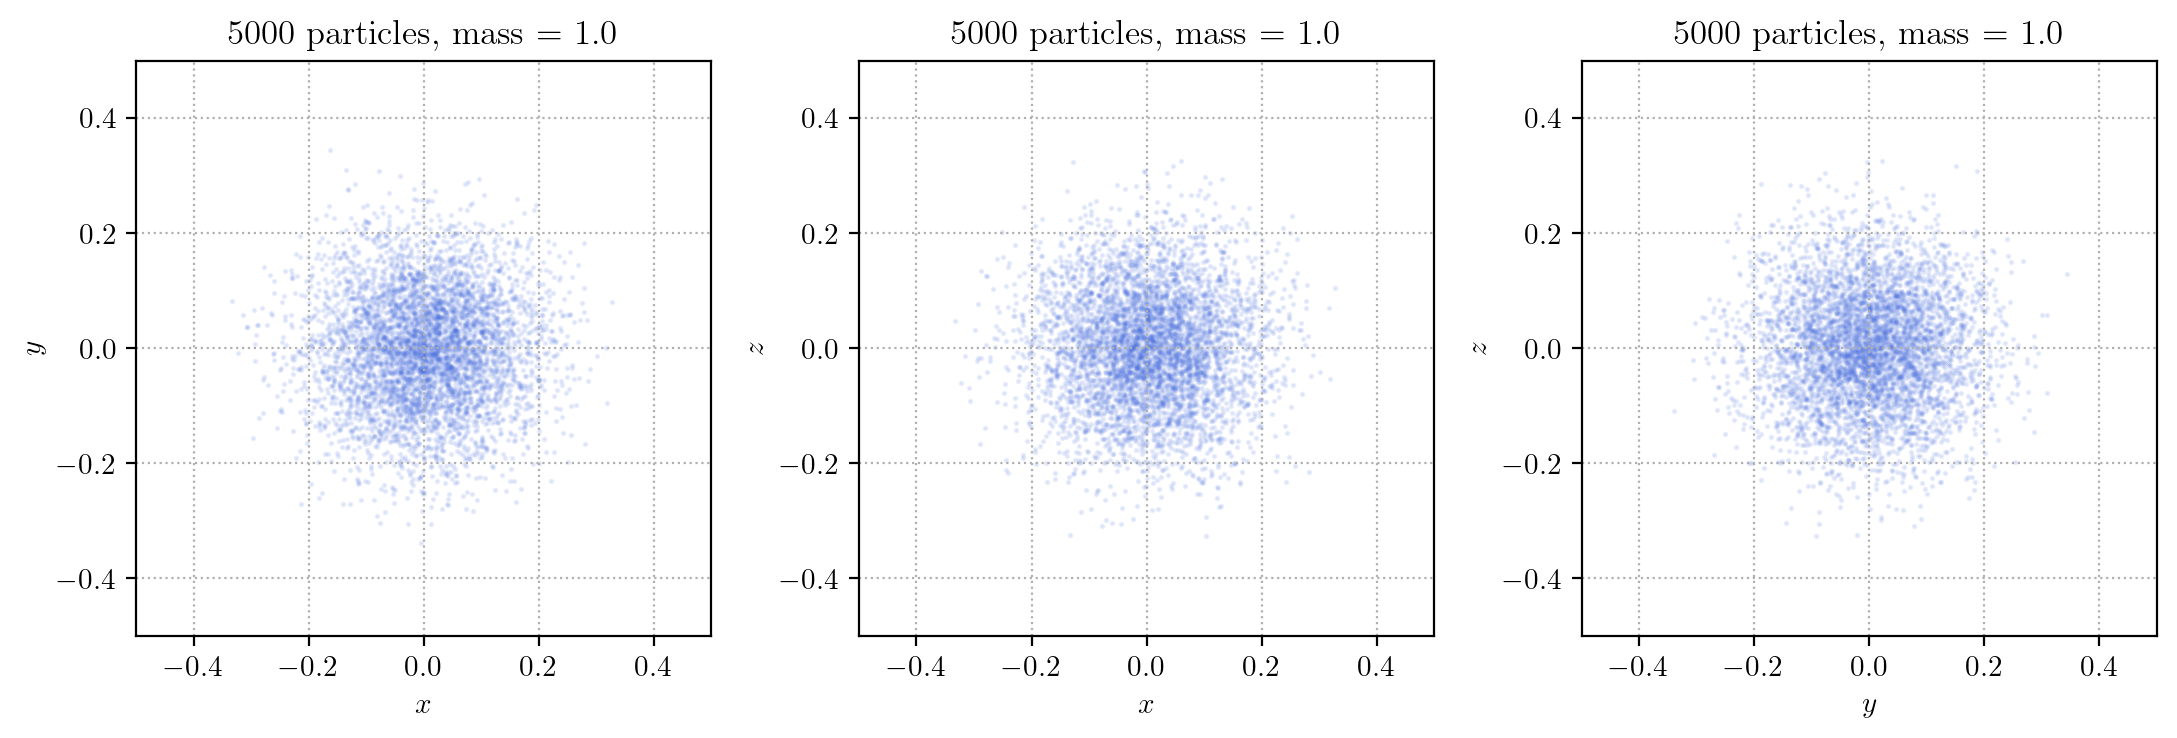

In [57]:
sphere.v_projections(s=1, a=.1, l=0.5);

## Simulation

In [61]:
home = '../../'
input = home + f'data/inputs/plummer{N}.txt' 
output = home + f'data/outputs/plummer{N}.txt'
log = f'../../data/outputs/plummer{N}_log.txt'

In [14]:
open(output, 'w').close() #clearing output file
sphere.write_tree(input)

Now we calculate the softening and accuracy parameters

In [62]:
V = 4/3*np.pi*b**3
epsilon = 1/100 * (V/int(float(N)))**(1/3)
T = np.sqrt(3 * np.pi/ (16*sphere.rho_mean_sphere(b))) #dynamical time

In [64]:
T_sim = round(3 * T)
dt = 1/8
theta = 0.1

print(f'T_sim = {T_sim:.1f} \t epsilon = {epsilon:.2e} \t dt = {dt:.2f}')

T_sim = 252.0 	 epsilon = 9.43e-03 	 dt = 0.12


In [18]:
os.system(home + f'treecode/tree/treecode in={input} out={output} eps={epsilon} tstop={T_sim} dtout={dt}>{log}')

0

In [65]:
import gdsam

pl = gdsam.plotter()
pl.get_data_tree(output)

Loaded 5e+03 particles


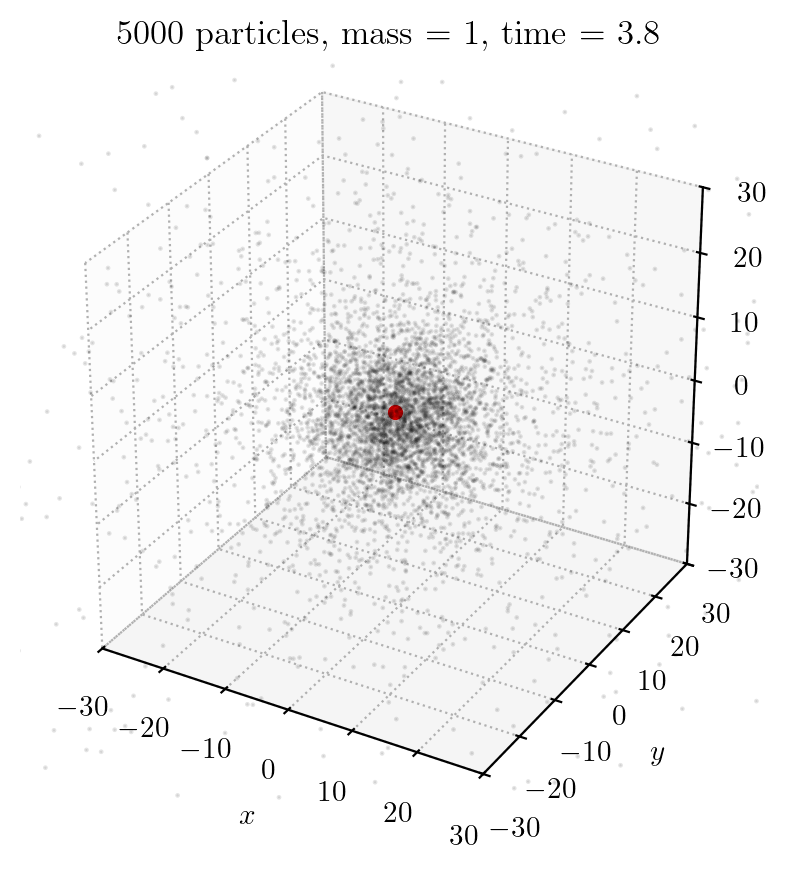

In [70]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
i = 30

x_cm, y_cm ,z_cm = pl.x_cm, pl.y_cm, pl.z_cm
pl.positions_3d(ax, num=i, l=30, b=0, a=.1, s=.5)
ax.scatter(x_cm[i], y_cm[i], z_cm[i], s=20, c='r')

plt.show()

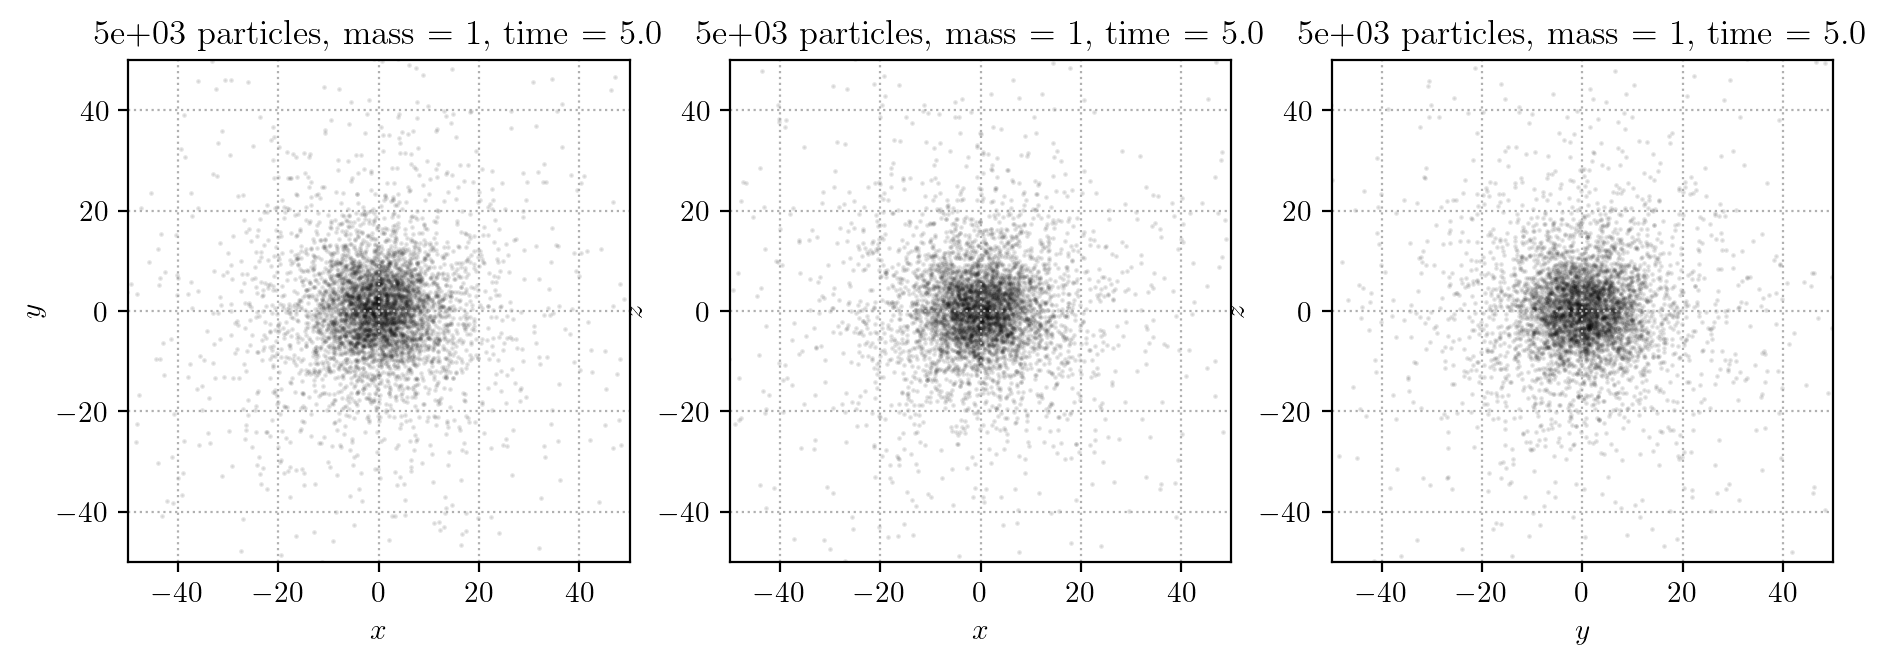

In [71]:
i=40
pl.projections(num=i, s=.5, a=.1, b=0, l=50)

plt.show()

  0%|          | 0/985 [00:00<?, ?it/s]

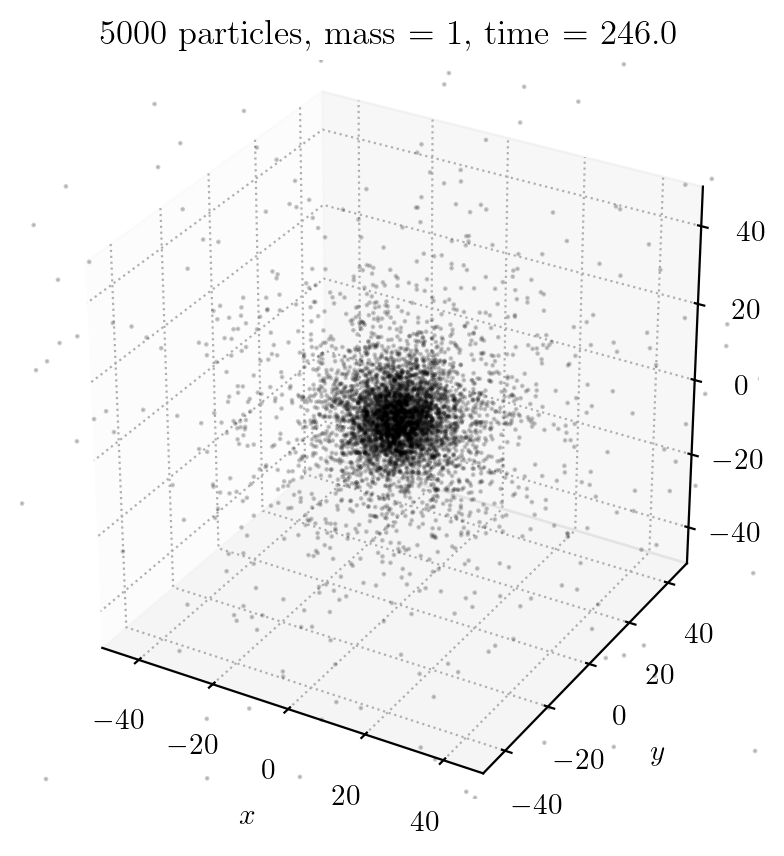

In [72]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ani = pl.animate_3d(fig, ax, b=0, l=50, s=.5, a=.1, frame_skip=2)

ani.save(f'../media/plummer_{N}.mp4', dpi=300, fps=30)

In [73]:
from IPython.display import Video

Video(filename=f'../media/plummer_{N}.mp4', width=600)